# Super-duper Basic NN's in Pytorch
----------------------------------------

# Outline

1. Linear Regression as the simplest NN
2. Feed Forward Neural Network
3. Recurrent Neural Network (RNN), (LSTM and GRU)
4. Convolutional Neural Network
5. GANs

All code available at [my github repo](https://github.com/richardagalvez/basic-intro-pytorch).

# 1.Linear Regression

More in-depth reference available [here](https://www.cs.cmu.edu/afs/cs.cmu.edu/academic/class/15381-s06/www/nn.pdf).

In a sense, the simplest Neural Network is a linear regression model:

![linear regression](https://cdn.pbrd.co/images/Hs1n4DL.png)

- $x_i$: input data
- $y_i$: output
- $w_i$: learned parameters

method:  adjust $w_i$'s until you have the best fit.

## Fitting model:

First, initiate $w_i$'s in some meaningful way (usually it's drawn from a uniform random distribution).

**Algorith:** continue until loss doesn't change much..

1. calculate prediction $\hat{y}$
  
2. calculate loss: L($y,\hat{y}$)
  
3. backprop

### Loss function and backprop

To figure out how well our prediction was, we'll use a basic loss function, mean squared error (MSE):

$L(y,\hat{y}) = ||~ y-\hat{y} ~||^2$,

ultimately trying to find $L_{\rm min}$, defined by the point in parameter space where $\nabla_{w_i} L = 0$.

Per-iteration update: 

$ w_i \to w_i - \eta \nabla_{w_i} L $,

where $\eta$ is known as the learning rate; too small and takes very long to converge, too big and you oscillate about the minimum.

----------------------------------------

Oh well, let's get started. First I'll import some basic things and set some preferences:

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
cmap=plt.cm.tab10
c = cycler('color', cmap(np.linspace(0,1,10)))
plt.rcParams["axes.prop_cycle"] = c
#plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable

## Ex. Teaching a machine to add

### A. Linear method:

In [10]:
%%time
class Additions(nn.Module):
    def __init__(self):
        super(Additions, self).__init__()
        self.layer1=nn.Linear(2,1,bias=False)
    def forward(self, x):
        out = self.layer1(x)
        return out

model=Additions()
optimizer=torch.optim.Adam(model.parameters())
criterion=nn.MSELoss()
print(model)

total_loss=[]
num_samples=1000
for k in range(num_samples):
    # =================== progress indicator ===================
    if k % (num_samples//5) ==0:
        print('{0}: %: {1:.3f}'.format(k,k/num_samples * 100))
    # =================== data prep ===================
    x=4*torch.rand(2)
    data,target=Variable(x),Variable(x[0]+x[1])
    # data,target=data.cuda(),target.cuda()
    # =================== forward =====================
    output=model(data)
    loss=criterion(output, target)
    total_loss.append(loss)
    # =================== backprop ====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Additions(
  (layer1): Linear(in_features=2, out_features=1, bias=False)
)
0: %: 0.000
200: %: 20.000
400: %: 40.000
600: %: 60.000
800: %: 80.000
CPU times: user 121 ms, sys: 14.2 ms, total: 135 ms
Wall time: 131 ms


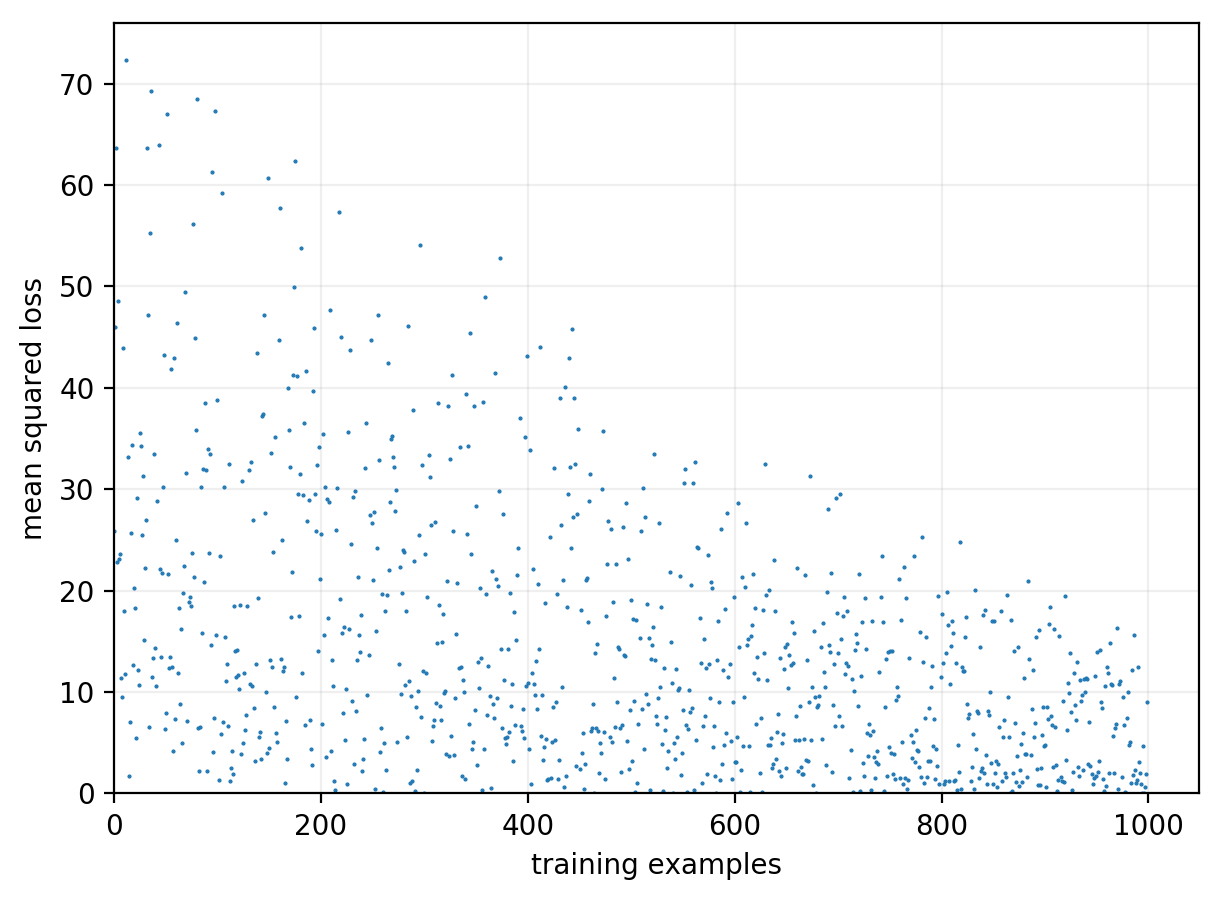

In [11]:
fig,ax=plt.subplots(figsize=(7,5))
ax.plot(total_loss,marker='.',ls='',markersize=1.)
ax.set_ylim(0,);ax.set_xlim(0,);ax.grid(alpha=0.2);
ax.set_xlabel('training examples');ax.set_ylabel('mean squared loss');

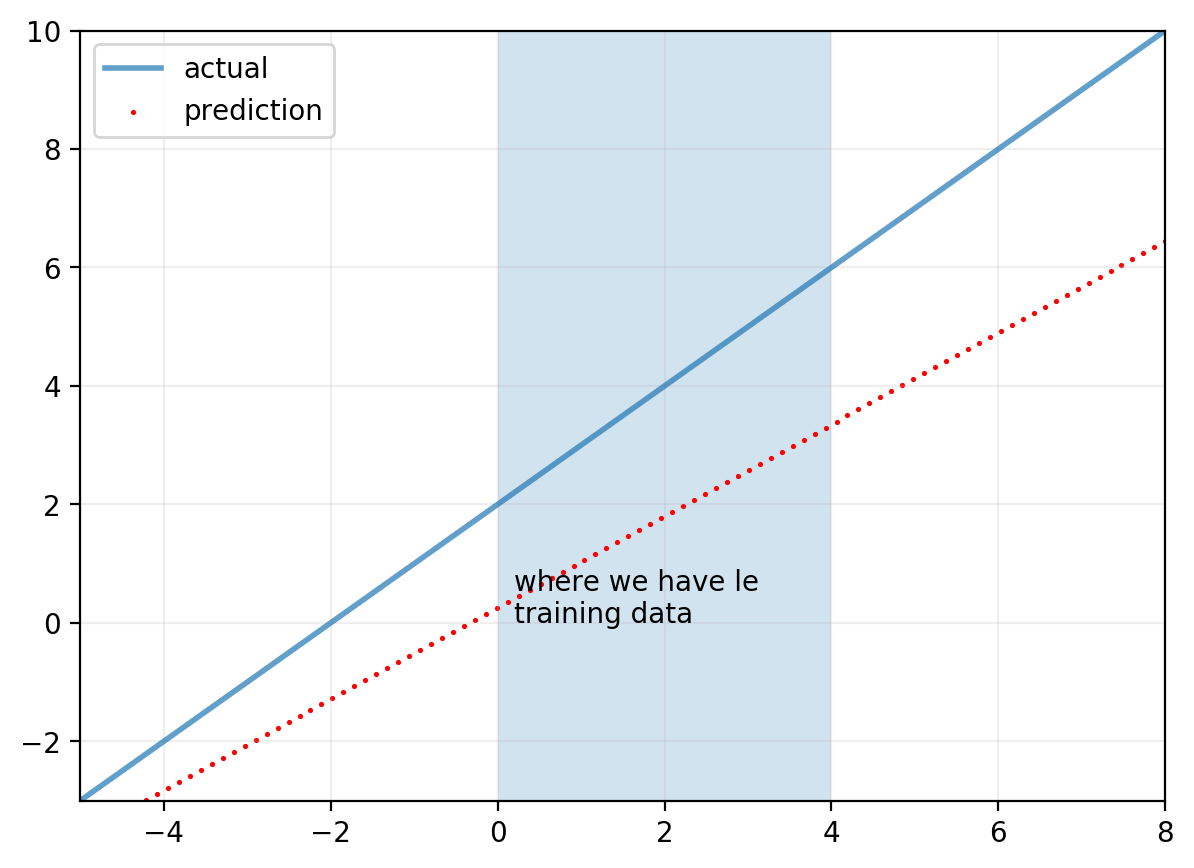

In [12]:
x,y=np.linspace(-5,8,100),[]

for xx in x:
    yy=model(torch.tensor([xx,2])).data.cpu().numpy()[0]
    y.append(yy)
y=np.array(y)

fig,ax=plt.subplots(figsize=(7,5))
ax.plot([-5,8],[-3,10],lw=2.0,label='actual',alpha=0.7)
ax.fill_betweenx([-3,10],0,4,alpha=0.2)
ax.scatter(x,y,marker='.',s=3.,label='prediction',color='r')
ax.text(0.2,0,'where we have le \ntraining data')
ax.legend()
ax.set_ylim(-3,10);ax.set_xlim(-5,8);
ax.grid(alpha=0.2);
#ax.set_xlabel('training examples');ax.set_ylabel('mean squared loss');

----------------------------------------
# 2. Feedforward Neural Network

![General Feed Forward Network](https://www.jeremyjordan.me/content/images/2017/07/Screen-Shot-2017-07-26-at-1.44.58-PM.png)

For our case of learning linear relationships, the modification to the linear regression architecture is depicted below:


![non-linear activation](https://cdn.pbrd.co/images/Hs3GrKM.png)

where

$$\sigma(z) = \frac{1}{1+e^{-z}}$$

is the so-called sigmoid function; this is typically the activation function that is first introduced, I think because of historical reasons. In modern practice, it finds most of its use in transforming single outputs from a NN into a probability. It's worth noting that if your NN will output multiple probabilities, for example, if your NN will categorize between black cats, red cats, white cats, etc., a multi-dimensional generalization of the sigmoid, called the softmax function, is typically used. 

The motivation behind adding an activation function is the hope that the NN model may capture non-linear relationships that exist in the data. Below are some commonly used activation functions. 

![activation functions](https://cdn-images-1.medium.com/max/1200/1*ZafDv3VUm60Eh10OeJu1vw.png)

In practice, a lot of architectures use the rectified linear unit (ReLU), along with it's close cousin, the so-called leaky-ReLU. In introducing this idea though, let's focus on the sigmoid which maps real numbers from $(-\infty,\infty) \to [0,1]$.

Of course our data is linear in the case of a straight line (!) but let's see what happens if we try to force a non-linear activation layer to capture a linear relationship..

## 2B. Nonlinear model for a linear relationship

### Deep Feedforward Network with sigmoid activation

In [140]:
%%time
class NLAdditions(nn.Module):
    def __init__(self):
        super(NLAdditions, self).__init__()
        self.layer1=nn.Sequential(
            nn.Linear(2,20),
            nn.Sigmoid(),
            nn.Linear(20,20),
            nn.Sigmoid(),
            nn.Linear(20,20),
            nn.Sigmoid(),
            nn.Linear(20,1))
    def forward(self, x):
        out = self.layer1(x)
        return out

model=NLAdditions()
optimizer=torch.optim.Adam(model.parameters())
criterion=nn.MSELoss()
total_loss=[]
print(model)

total_loss=[]
num_samples=25000
for k in range(num_samples):
    # =================== progress indicator ===================
    if k % (num_samples//5) ==0:
        print('{0}: %: {1:.3f}'.format(k,k/num_samples * 100))
    # =================== data prep ===================
    x=4*torch.rand(2)
    data,target=Variable(x),Variable(x[0]+x[1])
    # =================== forward =====================
    output=model(data)
    loss=criterion(output, target)
    total_loss.append(loss)
    # =================== backprop ====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

NLAdditions(
  (layer1): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=20, out_features=1, bias=True)
  )
)
0: %: 0.000
5000: %: 20.000
10000: %: 40.000
15000: %: 60.000
20000: %: 80.000
CPU times: user 9.2 s, sys: 412 ms, total: 9.61 s
Wall time: 9.62 s


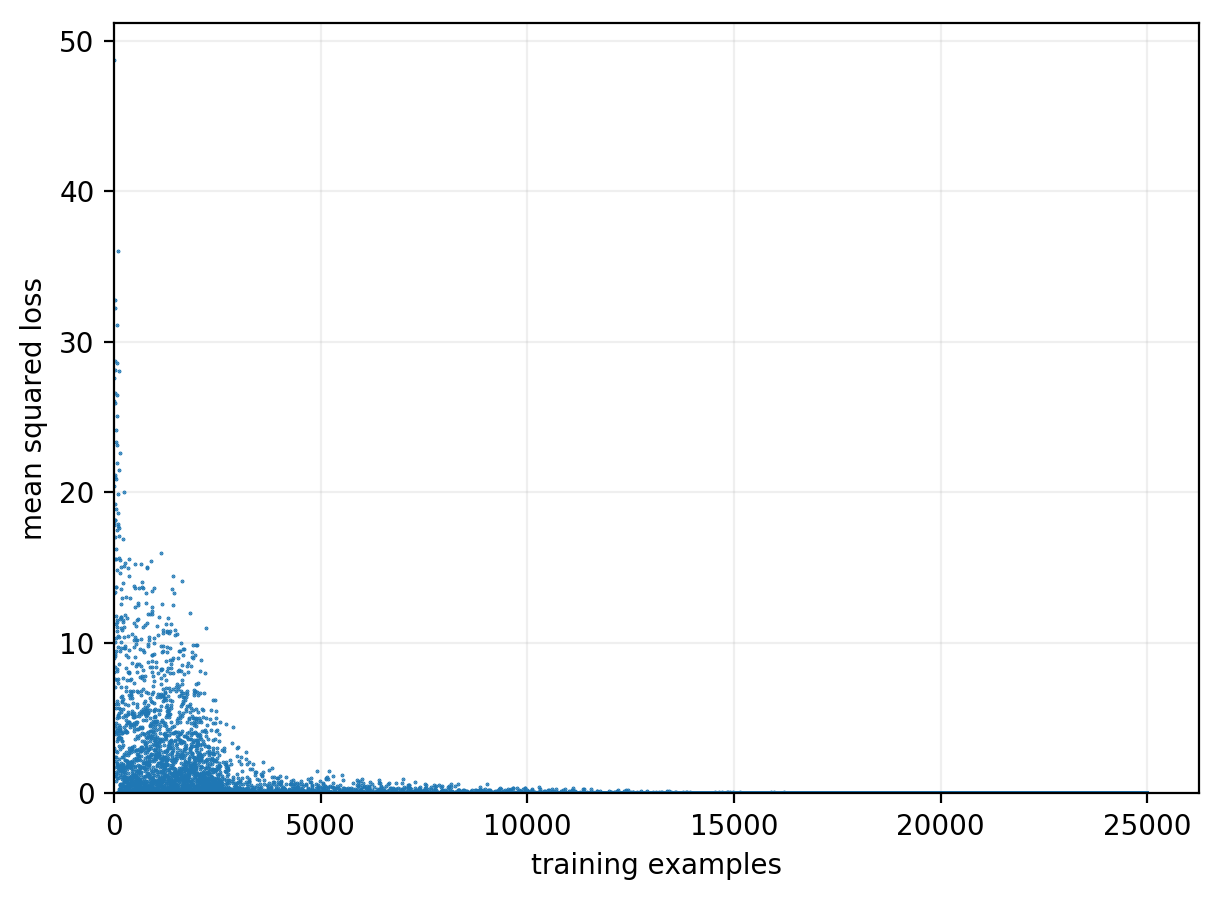

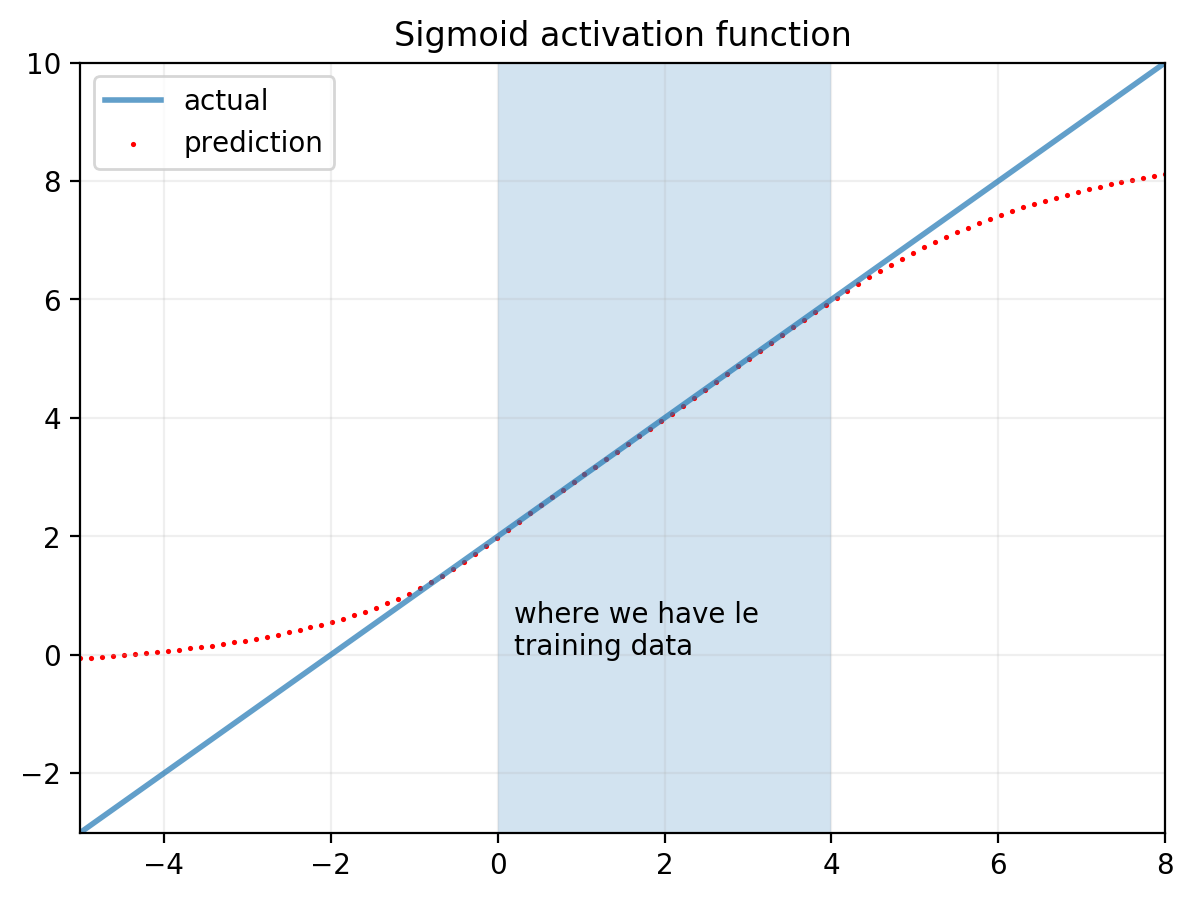

In [141]:
fig,ax=plt.subplots(figsize=(7,5))
ax.plot(total_loss,marker='.',ls='',markersize=.8)
ax.set_ylim(0,);ax.set_xlim(0,);ax.grid(alpha=0.2);
ax.set_xlabel('training examples');ax.set_ylabel('mean squared loss');

x,y=np.linspace(-5,8,100),[]

for xx in x:
    yy=model(torch.tensor([xx,2])).data.cpu().numpy()[0]
    y.append(yy)
y=np.array(y)

fig,ax=plt.subplots(figsize=(7,5))
ax.plot([-5,8],[-3,10],lw=2.0,label='actual',alpha=0.7)
ax.fill_betweenx([-3,10],0,4,alpha=0.2)
ax.scatter(x,y,marker='.',s=3.,label='prediction',color='r')
ax.text(0.2,0,'where we have le \ntraining data')
ax.legend()
ax.set_ylim(-3,10);ax.set_xlim(-5,8);
ax.grid(alpha=0.2);
ax.set_title('Sigmoid activation function');

The interesting thing to note here is that a non-linear feedforward network can approximate a linear relationship, but constrained to the training data range

### B2. ReLU activation function

In [142]:
%%time
class NLAdditions(nn.Module):
    def __init__(self):
        super(NLAdditions, self).__init__()
        self.layer1=nn.Sequential(
            nn.Linear(2,20),
            nn.ReLU(),
            nn.Linear(20,20),
            nn.ReLU(),
            nn.Linear(20,20),
            nn.ReLU(),
            nn.Linear(20,1))
    def forward(self, x):
        out = self.layer1(x)
        return out

model=NLAdditions()
optimizer=torch.optim.Adam(model.parameters())
criterion=nn.MSELoss()
total_loss=[]
print(model)

total_loss=[]
num_samples=25000
for k in range(num_samples):
    # =================== progress indicator ===================
    if k % (num_samples//5) ==0:
        print('{0}: %: {1:.3f}'.format(k,k/num_samples * 100))
    # =================== data prep ===================
    x=4*torch.rand(2)
    data,target=Variable(x),Variable(x[0]+x[1])
    # data,target=data.cuda(),target.cuda()
    # =================== forward =====================
    output=model(data)
    loss=criterion(output, target)
    total_loss.append(loss)
    # =================== backprop ====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

NLAdditions(
  (layer1): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=1, bias=True)
  )
)
0: %: 0.000
5000: %: 20.000
10000: %: 40.000
15000: %: 60.000
20000: %: 80.000
CPU times: user 11.7 s, sys: 549 ms, total: 12.3 s
Wall time: 12.3 s


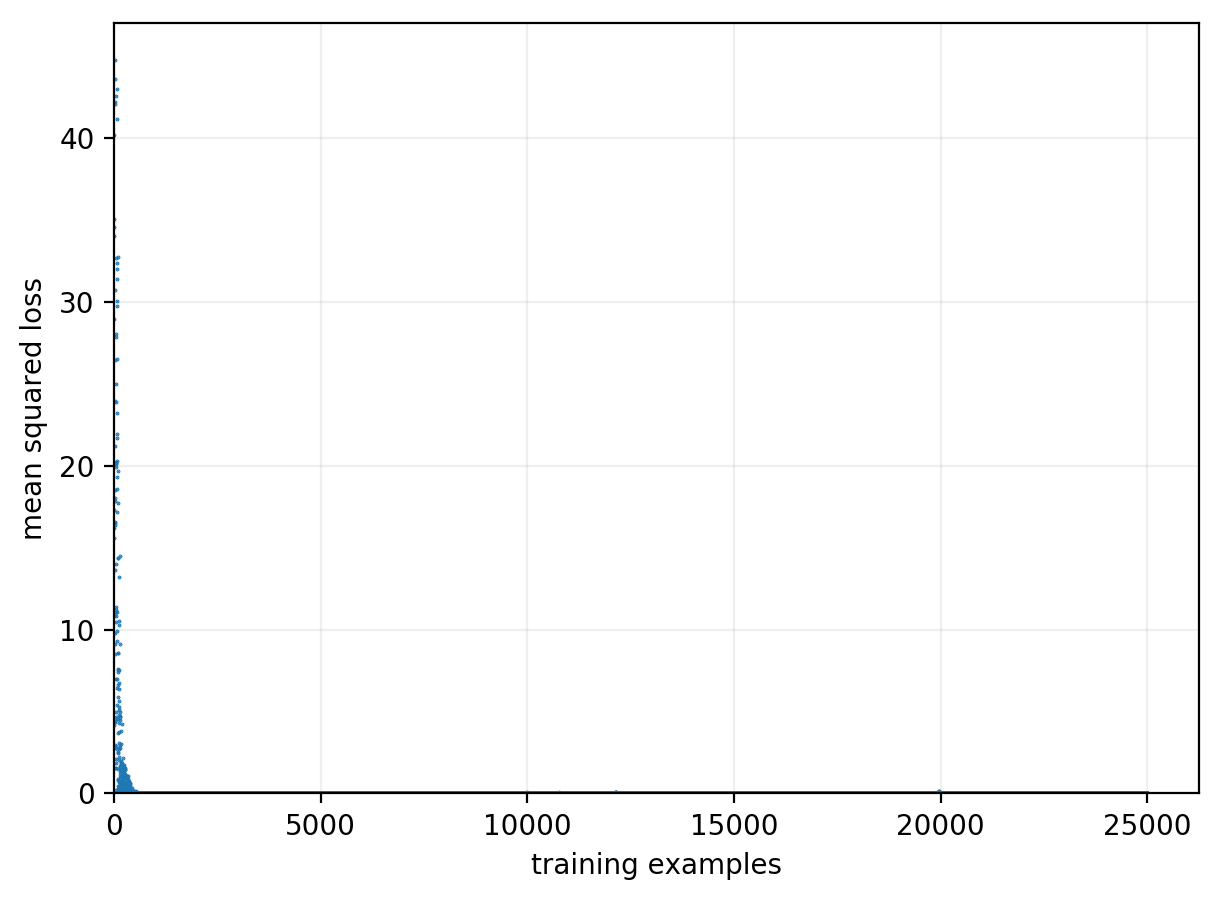

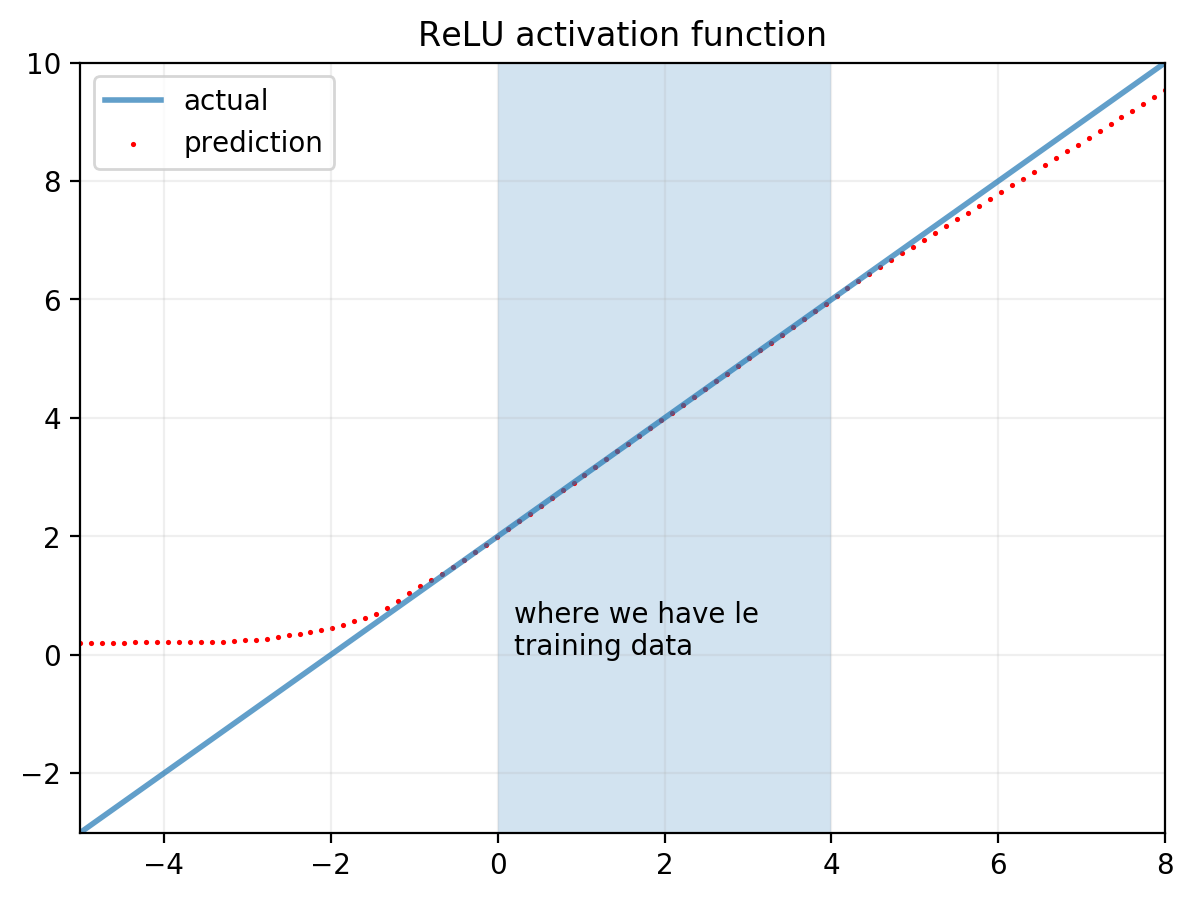

In [143]:
fig,ax=plt.subplots(figsize=(7,5))
ax.plot(total_loss,marker='.',ls='',markersize=.8)
ax.set_ylim(0,);ax.set_xlim(0,);ax.grid(alpha=0.2);
ax.set_xlabel('training examples');ax.set_ylabel('mean squared loss');

x,y=np.linspace(-5,8,100),[]

for xx in x:
    yy=model(torch.tensor([xx,2])).data.cpu().numpy()[0]
    y.append(yy)
y=np.array(y)

fig,ax=plt.subplots(figsize=(7,5))
ax.plot([-5,8],[-3,10],lw=2.0,label='actual',alpha=0.7)
ax.fill_betweenx([-3,10],0,4,alpha=0.2)
ax.scatter(x,y,marker='.',s=3.,label='prediction',color='r')
ax.text(0.2,0,'where we have le \ntraining data')
ax.legend()
ax.set_ylim(-3,10);ax.set_xlim(-5,8);
ax.grid(alpha=0.2);
ax.set_title('ReLU activation function');

### B3. Tanh activation function

NLAdditions(
  (layer1): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=1, bias=True)
  )
)
0: %: 0.000
10000: %: 20.000
20000: %: 40.000
30000: %: 60.000
40000: %: 80.000
CPU times: user 18.8 s, sys: 739 ms, total: 19.5 s
Wall time: 19.5 s


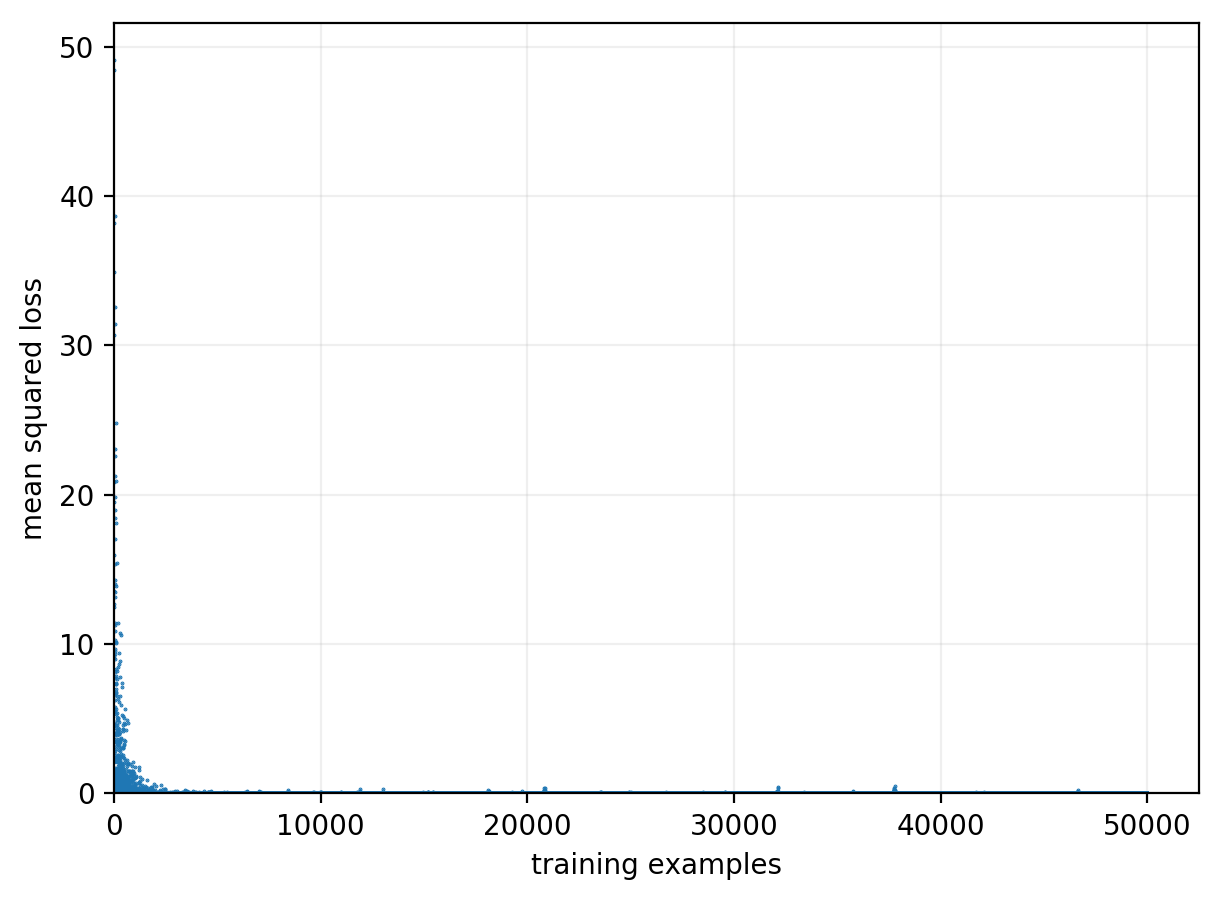

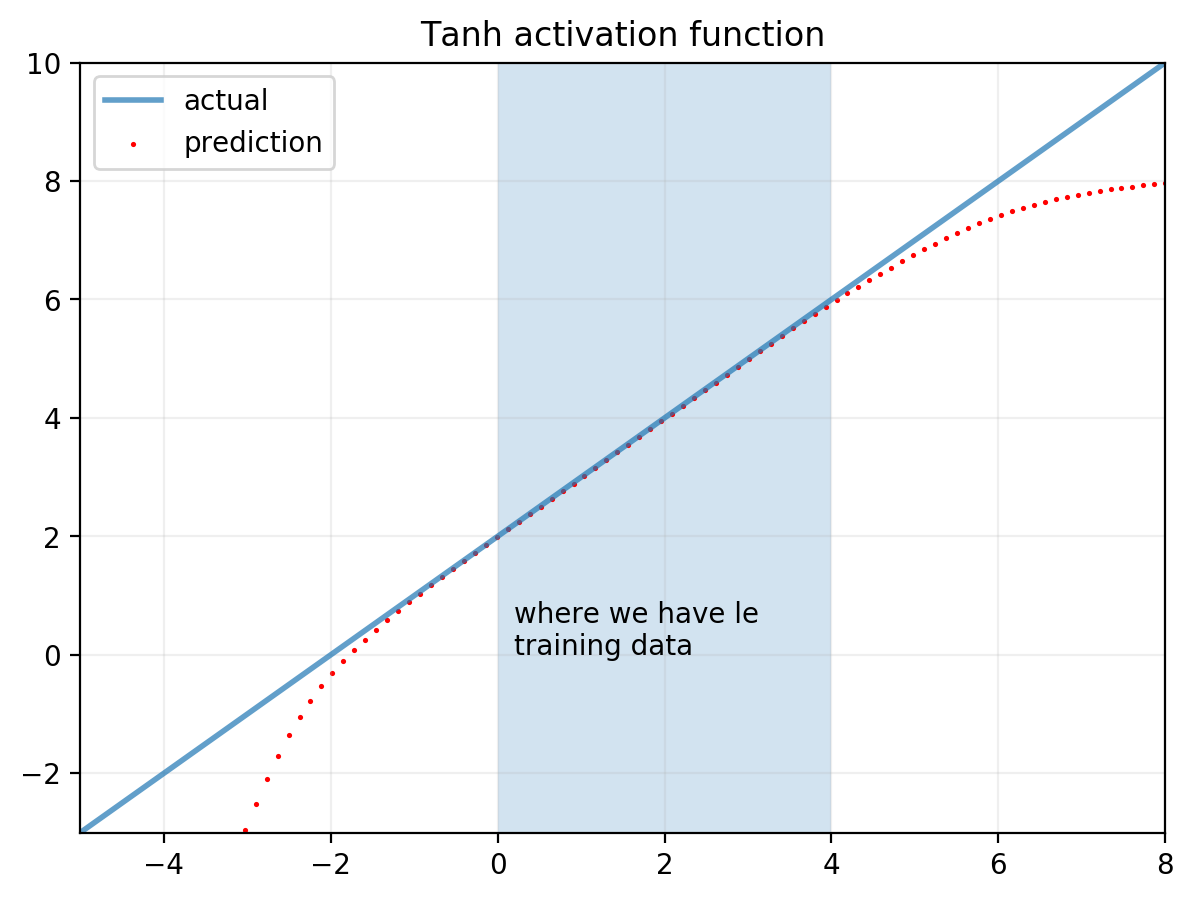

In [145]:
%%time
class NLAdditions(nn.Module):
    def __init__(self):
        super(NLAdditions, self).__init__()
        self.layer1=nn.Sequential(
            nn.Linear(2,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,1))
    def forward(self, x):
        out = self.layer1(x)
        return out

model=NLAdditions()
optimizer=torch.optim.Adam(model.parameters())
criterion=nn.MSELoss()
total_loss=[]
print(model)

total_loss=[]
num_samples=50000
for k in range(num_samples):
    # =================== progress indicator ===================
    if k % (num_samples//5) ==0:
        print('{0}: %: {1:.3f}'.format(k,k/num_samples * 100))
    # =================== data prep ===================
    x=4*torch.rand(2)
    data,target=Variable(x),Variable(x[0]+x[1])
    # data,target=data.cuda(),target.cuda()
    # =================== forward =====================
    output=model(data)
    loss=criterion(output, target)
    total_loss.append(loss)
    # =================== backprop ====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

fig,ax=plt.subplots(figsize=(7,5))
ax.plot(total_loss,marker='.',ls='',markersize=.8)
ax.set_ylim(0,);ax.set_xlim(0,);ax.grid(alpha=0.2);
ax.set_xlabel('training examples');ax.set_ylabel('mean squared loss');

x,y=np.linspace(-5,8,100),[]

for xx in x:
    yy=model(torch.tensor([xx,2])).data.cpu().numpy()[0]
    y.append(yy)
y=np.array(y)

fig,ax=plt.subplots(figsize=(7,5))
ax.plot([-5,8],[-3,10],lw=2.0,label='actual',alpha=0.7)
ax.fill_betweenx([-3,10],0,4,alpha=0.2)
ax.scatter(x,y,marker='.',s=3.,label='prediction',color='r')
ax.text(0.2,0,'where we have le \ntraining data')
ax.legend()
ax.set_ylim(-3,10);ax.set_xlim(-5,8);
ax.grid(alpha=0.2);
ax.set_title('Tanh activation function');

----------------------------------------
## Ex 2. Teaching a machine to draw circles

Here the NN learns attempts to learn the 2d rotation matrix, parameterized by the generator of rotations in two dimensions:

$R={\begin{bmatrix}\cos \theta &-\sin \theta \\\sin \theta &\cos \theta \\\end{bmatrix}}$

0: %: 0.000
5000: %: 5.000
10000: %: 10.000
15000: %: 15.000
20000: %: 20.000
25000: %: 25.000
30000: %: 30.000
35000: %: 35.000
40000: %: 40.000
45000: %: 45.000
50000: %: 50.000
55000: %: 55.000
60000: %: 60.000
65000: %: 65.000
70000: %: 70.000
75000: %: 75.000
80000: %: 80.000
85000: %: 85.000
90000: %: 90.000
95000: %: 95.000
CPU times: user 37 s, sys: 1.21 s, total: 38.3 s
Wall time: 38.3 s


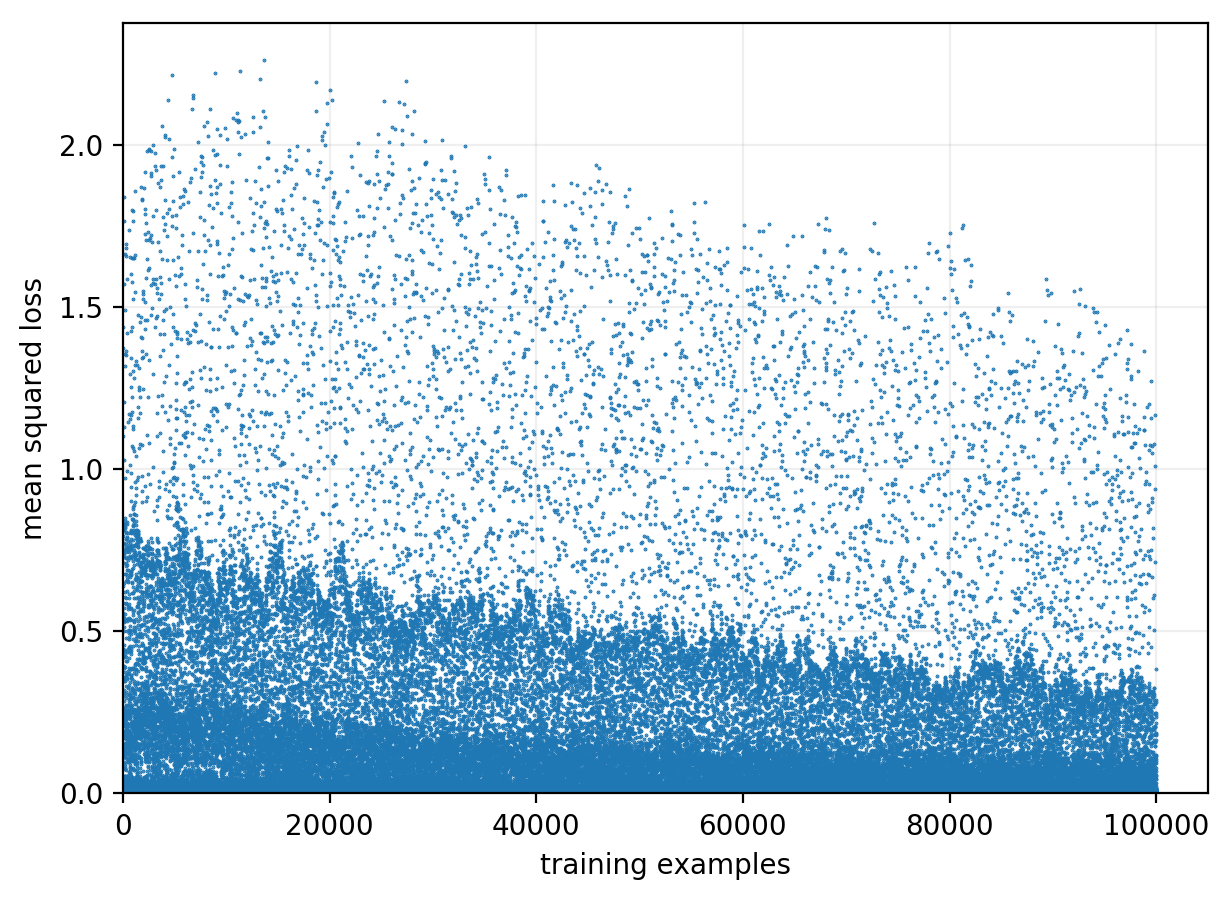

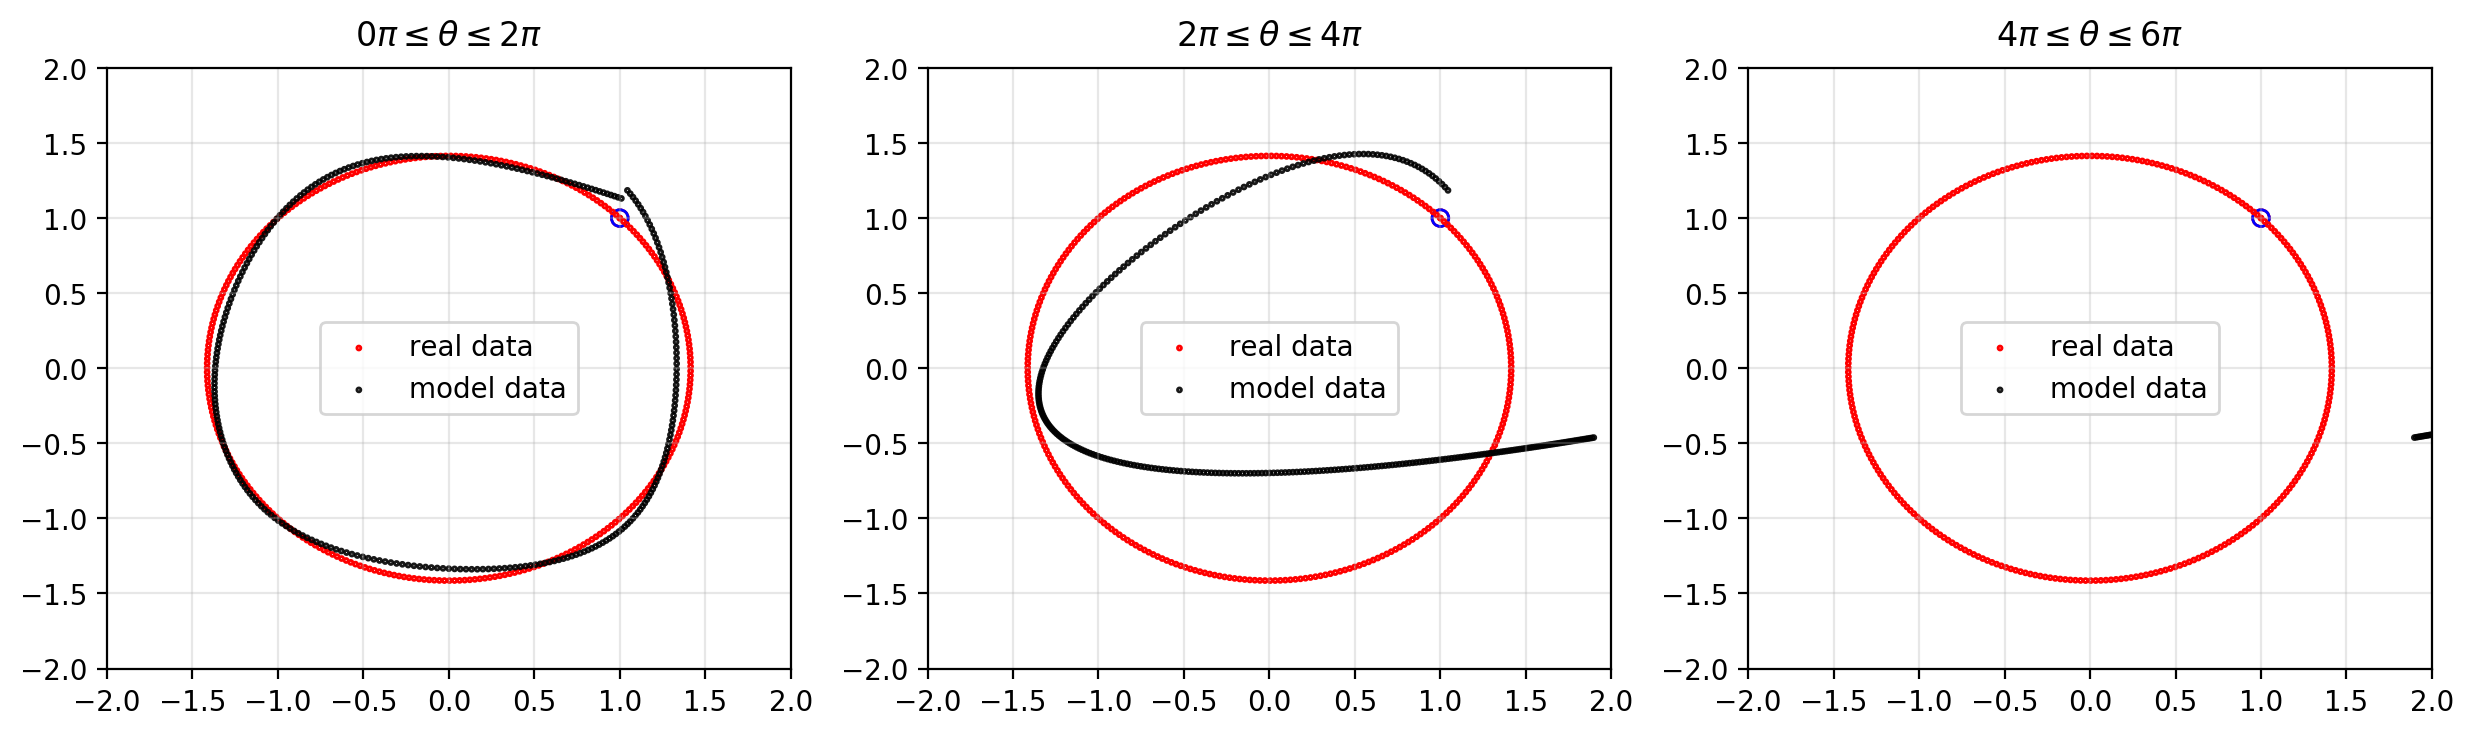

In [53]:
%%time
num_nodes=10
class Rotations(nn.Module):
    def __init__(self):
        super(Rotations, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(1,num_nodes),
            nn.Sigmoid(),
            nn.Linear(num_nodes,2))      
    def forward(self, x):
        out=self.layer1(x)
        return out

model=Rotations()
optimizer=torch.optim.Adam(model.parameters())
criterion=nn.MSELoss()
print(model)

total_loss,theta=train_models([model],[optimizer],num_samples=200000,circle_interval=2.0)

fig,ax=plt.subplots(figsize=(7,5))
ax.plot(total_loss,marker='.',ls='',markersize=.8)
ax.set_ylim(0,);ax.set_xlim(0,);ax.grid(alpha=0.2);
ax.set_xlabel('training examples');ax.set_ylabel('mean squared loss');

output=plot_circles([model],offset=0,CI=False,recurrent=False)

### deeper network?

Rotations(
  (layer1): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=10, out_features=2, bias=True)
  )
)
0: %: 0.000
10000: %: 5.000
20000: %: 10.000
30000: %: 15.000
40000: %: 20.000
50000: %: 25.000
60000: %: 30.000
70000: %: 35.000
80000: %: 40.000
90000: %: 45.000
100000: %: 50.000
110000: %: 55.000
120000: %: 60.000
130000: %: 65.000
140000: %: 70.000
150000: %: 75.000
160000: %: 80.000
170000: %: 85.000
180000: %: 90.000
190000: %: 95.000
CPU times: user 1min 44s, sys: 2.47 s, total: 1min 47s
Wall time: 1min 47s


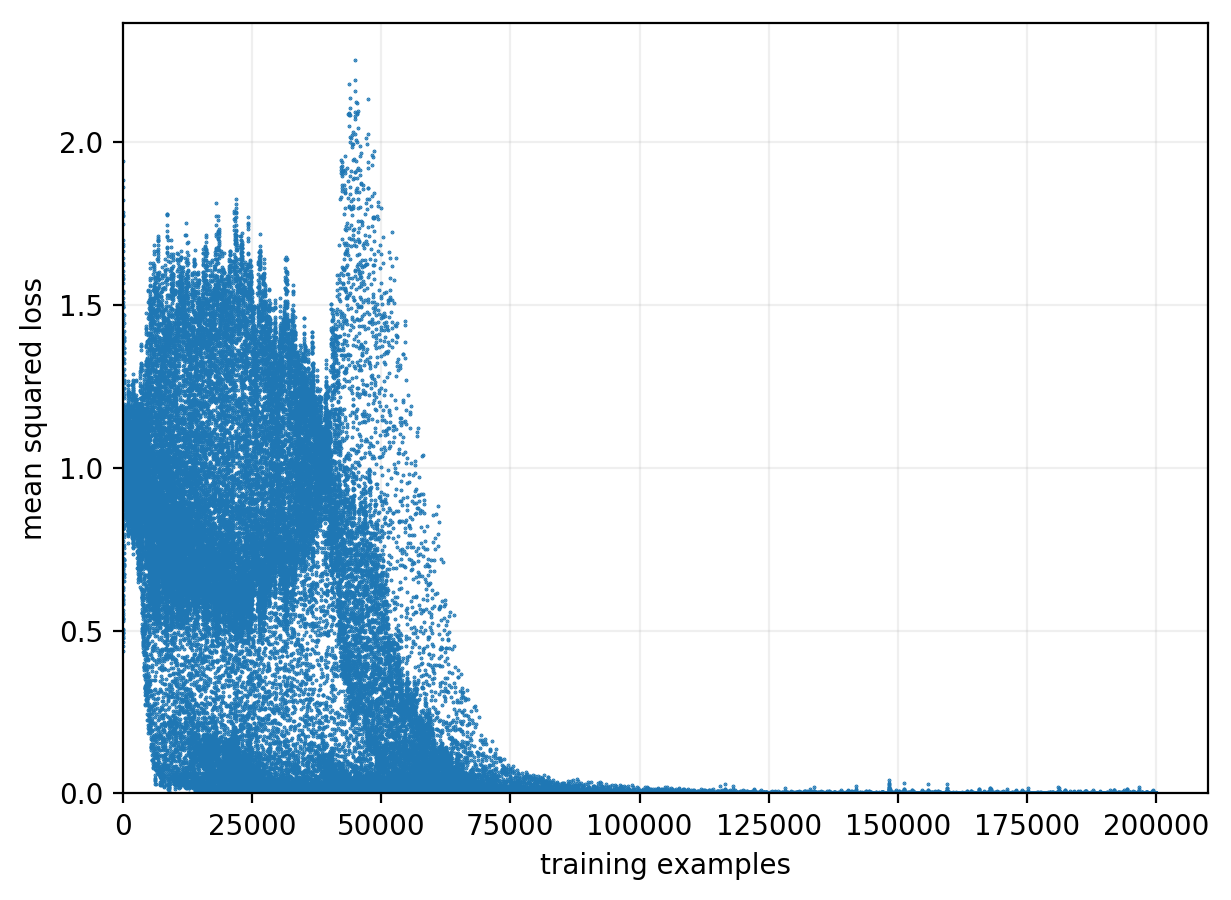

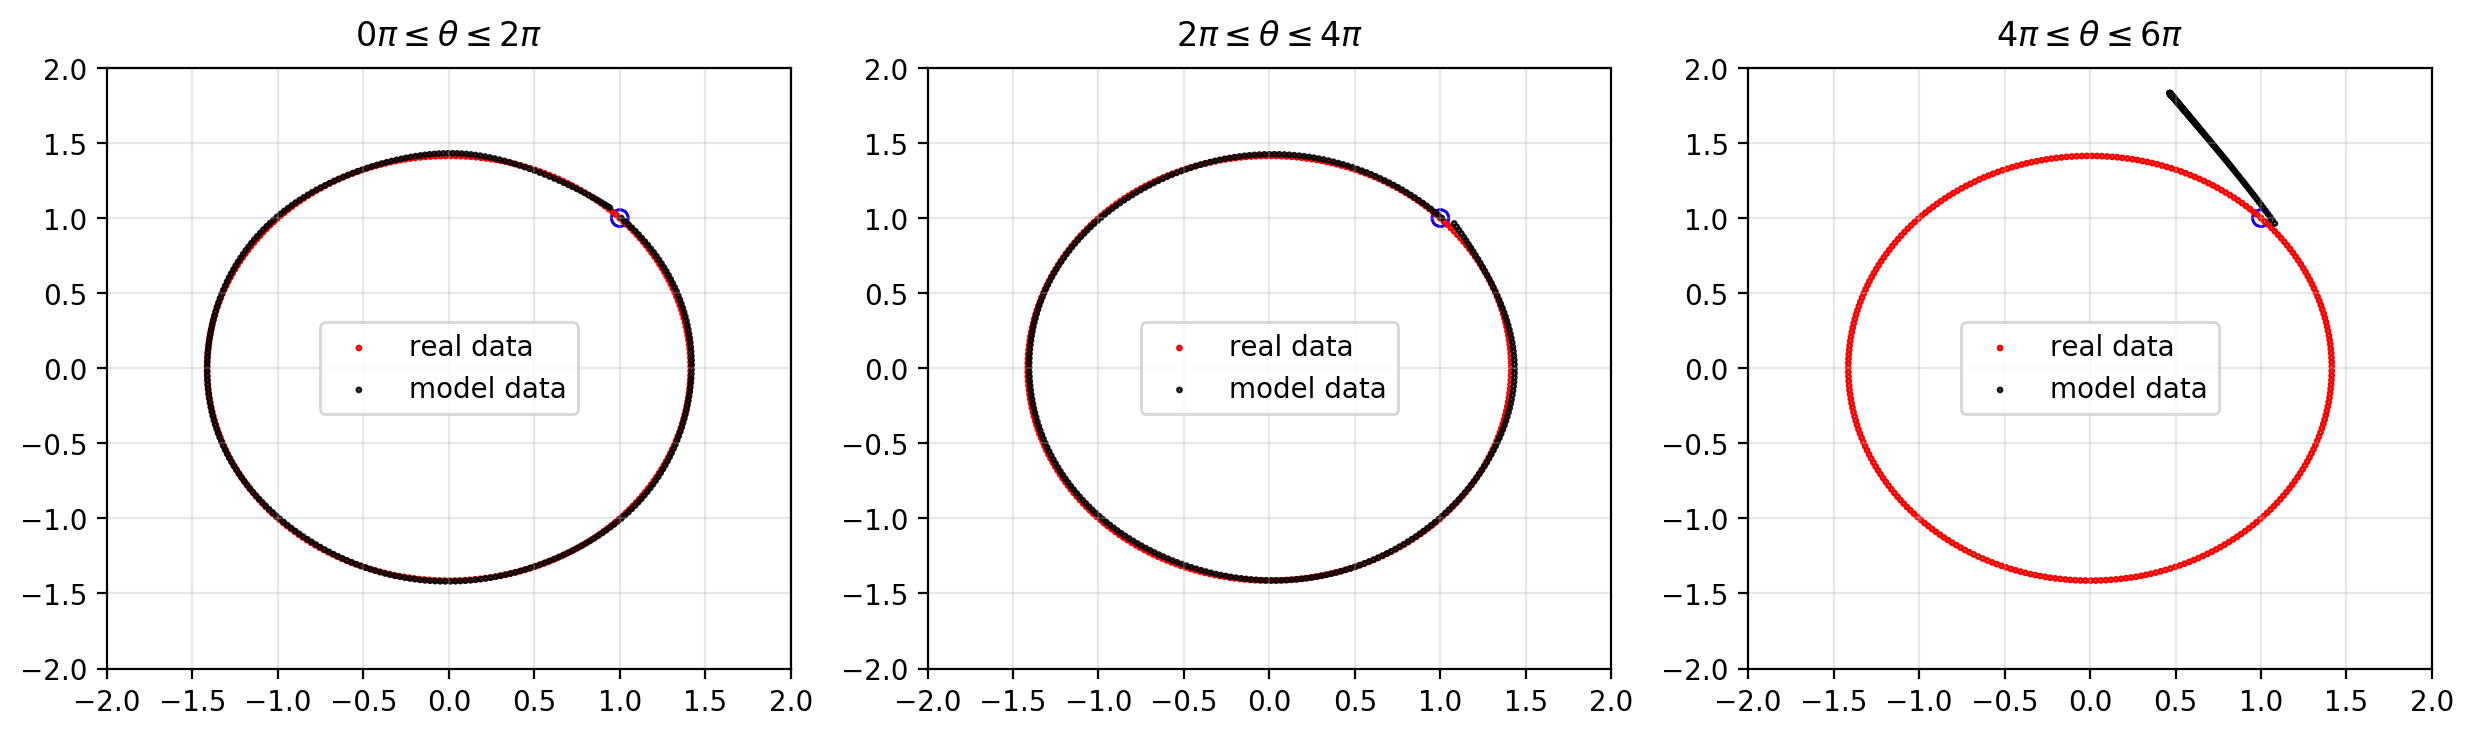

In [54]:
%%time
num_nodes=10
class Rotations(nn.Module):
    def __init__(self):
        super(Rotations, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(1,num_nodes),
            nn.Sigmoid(),
            nn.Linear(num_nodes,num_nodes),
            nn.Sigmoid(),
            nn.Linear(num_nodes,num_nodes),
            nn.Sigmoid(),
            nn.Linear(num_nodes,2))      
    def forward(self, x):
        out=self.layer1(x)
        return out

model=Rotations()
optimizer=torch.optim.Adam(model.parameters())
criterion=nn.MSELoss()
print(model)

total_loss,theta=train_models([model],[optimizer],num_samples=200000,circle_interval=2.0)

fig,ax=plt.subplots(figsize=(7,5))
ax.plot(total_loss,marker='.',ls='',markersize=.8)
ax.set_ylim(0,);ax.set_xlim(0,);ax.grid(alpha=0.2);
ax.set_xlabel('training examples');ax.set_ylabel('mean squared loss');

output=plot_circles([model],offset=0,CI=False,recurrent=False)

## Bayesian Approach

One simple approach to apply the bayesian method described by Yarin Gal, is to take multiple of the same models and train them independently. This allows each model to take independent paths through parameter space, usually finding their way near some optimal minima. In practice, this allows you to hedge the risk of getting stuck in some local minima and missing out on the global one, if it exists. 

The process I describe here is apparently identical to Yarin's description of sampling over various dropout probabilities, by a theorem he introduced during his talk, but I had not known of it until I heard his talk.

A visual way of understanding the situation of training a machine learning model, in general, is by considering a 3D surface plot where the x and y dimensions are two parameters you may modify, with the loss on the z axis, or height, which your aim is to minimize. 

![landscape of deep learning models](http://7xihzu.com1.z0.glb.clouddn.com/20160716/graphical-idea-backprop.png)

The surface that the data carves out in this space is predicated by the data; the aim of the model design is then to build a model flexible and robust enough to find the global minima, but not overly complex enough to overfit and get stuck at a local minima. Also, if your model is too simple, it can skip right over all the minima altogether, and not learn the nuance of the process described by the data. Having too high/low of a learning rate can also make the training process difficult.

My approach to make the training, and thereby prediction, take on a bayesian nature is to simply replicate the number of models I train, along with various optimizers:

0: %: 0.000
5000: %: 5.000
10000: %: 10.000
15000: %: 15.000
20000: %: 20.000
25000: %: 25.000
30000: %: 30.000
35000: %: 35.000
40000: %: 40.000
45000: %: 45.000
50000: %: 50.000
55000: %: 55.000
60000: %: 60.000
65000: %: 65.000
70000: %: 70.000
75000: %: 75.000
80000: %: 80.000
85000: %: 85.000
90000: %: 90.000
95000: %: 95.000


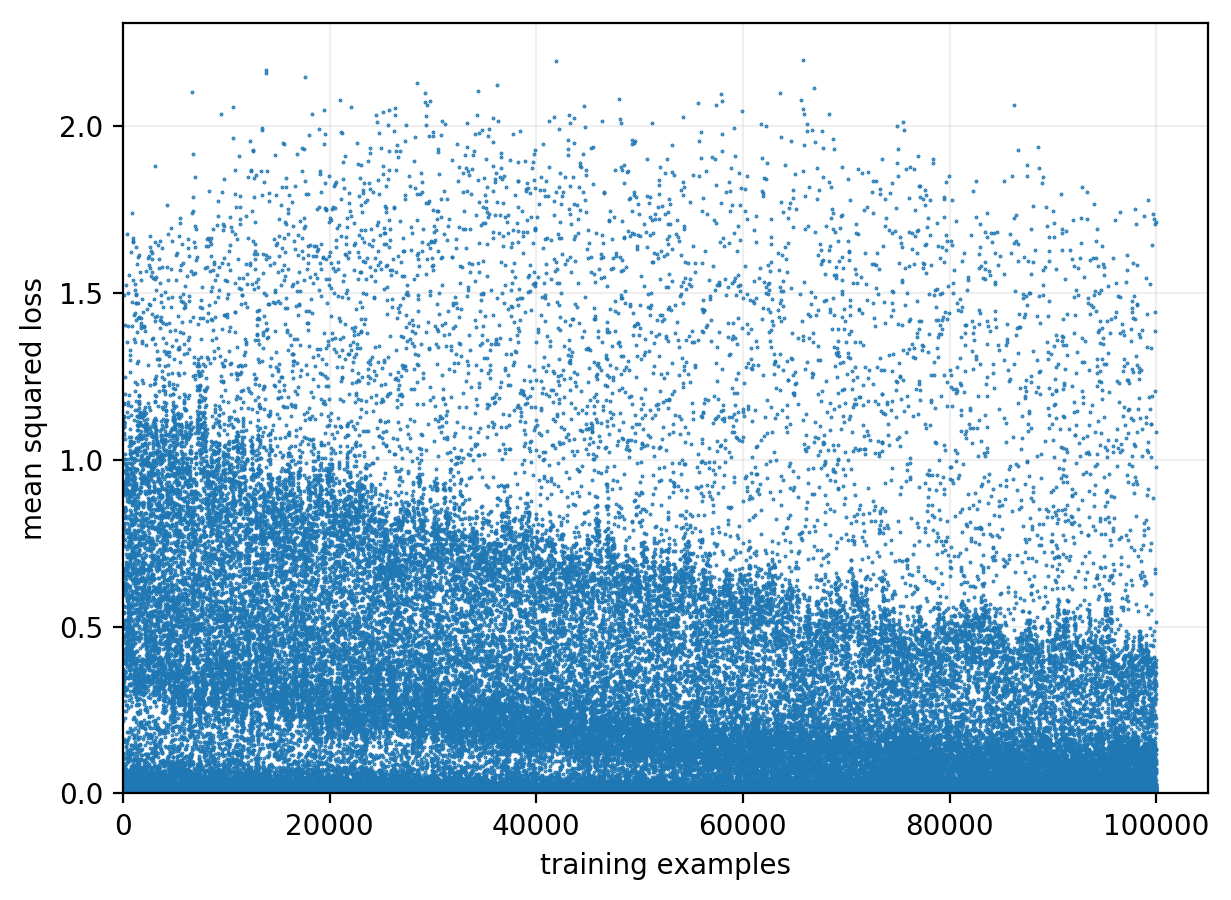

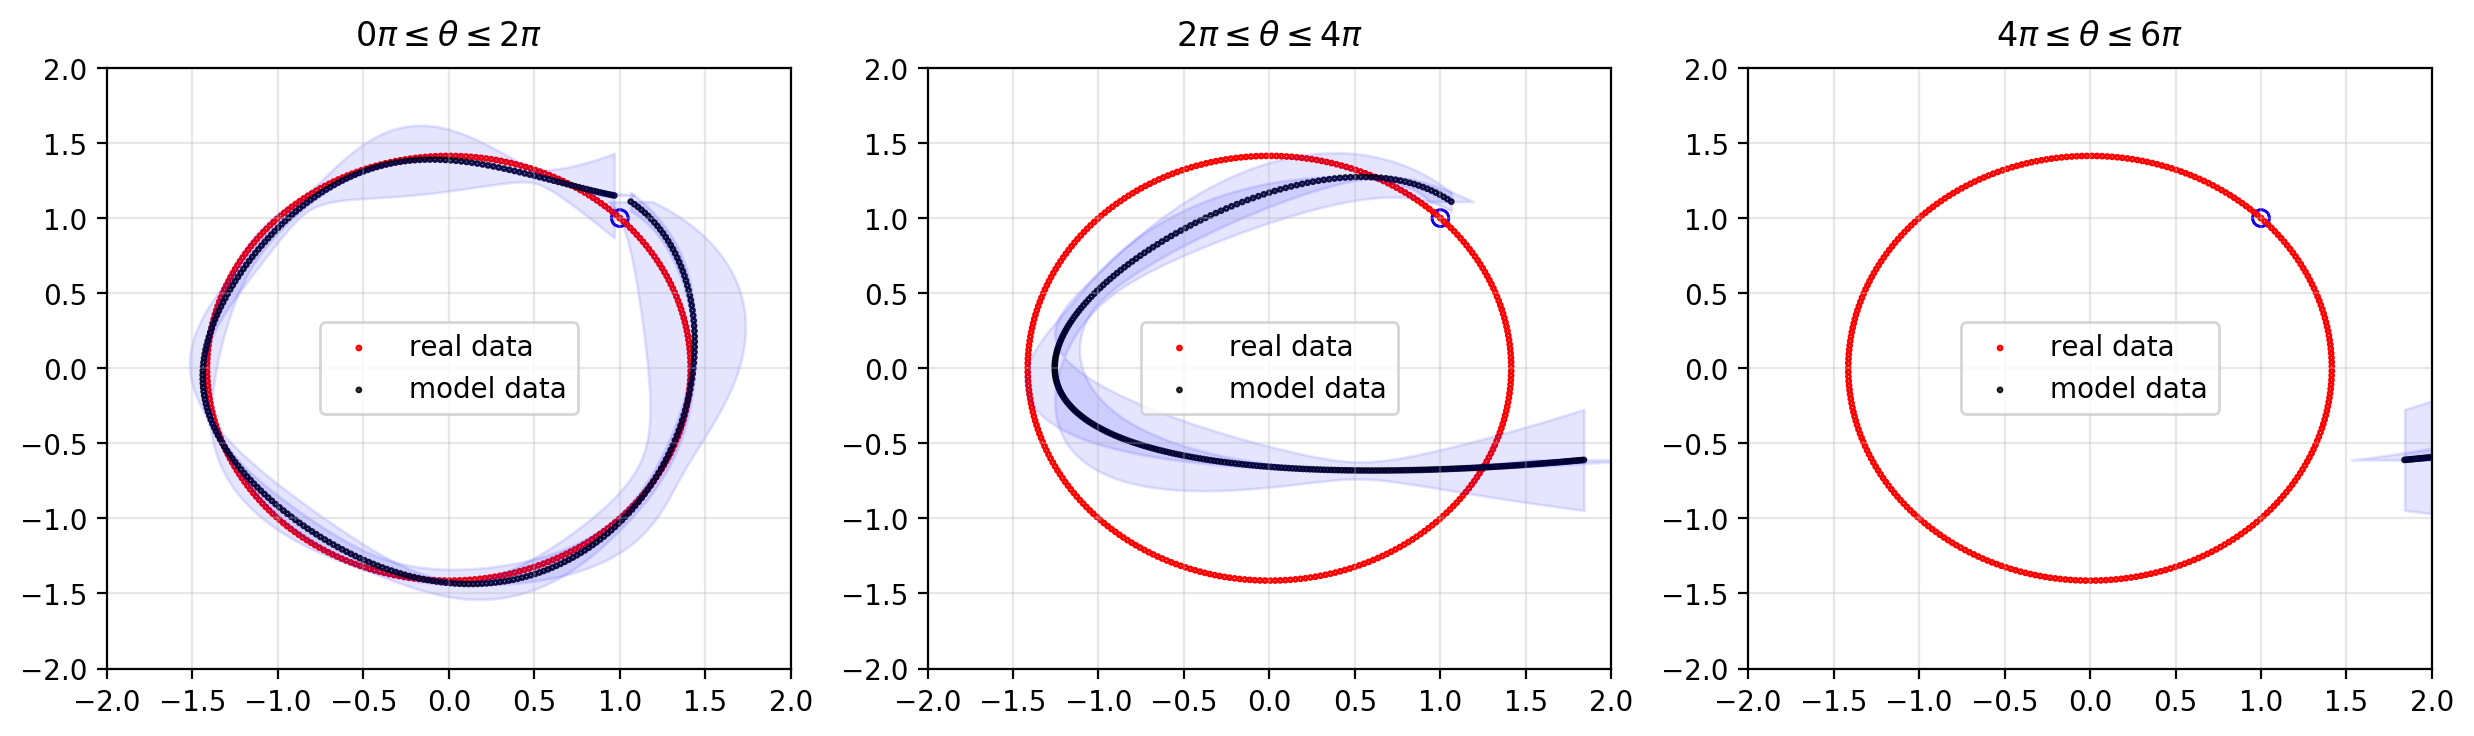

In [74]:
%%time
num_nodes=10
class Rotations(nn.Module):
    def __init__(self):
        super(Rotations, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(1,num_nodes),
            nn.Sigmoid(),
            nn.Linear(num_nodes,2))      
    def forward(self, x):
        out=self.layer1(x)
        return out

models = []
optimizers = []
for k in range(4): # in this case we allow 4 models to take their own paths in parameter space
    models.append(Rotations())
    models[-1].apply(weight_init)
    #models[-1].cuda()
    optimizers.append(torch.optim.Adam(models[-1].parameters()))

total_loss,theta=train_models(models,optimizers,num_samples=100000,circle_interval=2.0,recurrent=False)

fig,ax=plt.subplots(figsize=(7,5))
ax.plot(total_loss,marker='.',ls='',markersize=.8)
ax.set_ylim(0,);ax.set_xlim(0,);ax.grid(alpha=0.2);
ax.set_xlabel('training examples');ax.set_ylabel('mean squared loss');

output=plot_circles(models,offset=0,CI=True,recurrent=False)

The functions I defined for training and plotting the circles already extends for this case, and if you wish to understand how to do this for your own models, please study my code, or just come ask me to explain/help; I'm more than happy to help, regardless of challenge!

# Recurrent Nets: LSTM and GRUs
----------------------------

Stated extremely succinctly by [Colah](http://colah.github.io/posts/2015-08-Understanding-LSTMs/):

![credit: Colah](https://cdn.pbrd.co/images/HsbkYBD.png)

I suggest people to read the blog post above-- it's really a great explanation of recurrent neural nets.

![GRU](https://image.slidesharecdn.com/dlsl2017d2l2recurrentneuralnetworksi-170125171004/95/recurrent-neural-networks-i-d2l2-deep-learning-for-speech-and-language-upc-2017-33-638.jpg?cb=1485365064)

Rotations(
  (input): Linear(in_features=1, out_features=10, bias=True)
  (rnn): GRU(10, 10)
  (out): Linear(in_features=10, out_features=2, bias=True)
)
0: %: 0.000
5000: %: 5.000
10000: %: 10.000
15000: %: 15.000
20000: %: 20.000
25000: %: 25.000
30000: %: 30.000
35000: %: 35.000
40000: %: 40.000
45000: %: 45.000
50000: %: 50.000
55000: %: 55.000
60000: %: 60.000
65000: %: 65.000
70000: %: 70.000
75000: %: 75.000
80000: %: 80.000
85000: %: 85.000
90000: %: 90.000
95000: %: 95.000
CPU times: user 1min 18s, sys: 1.72 s, total: 1min 20s
Wall time: 1min 20s


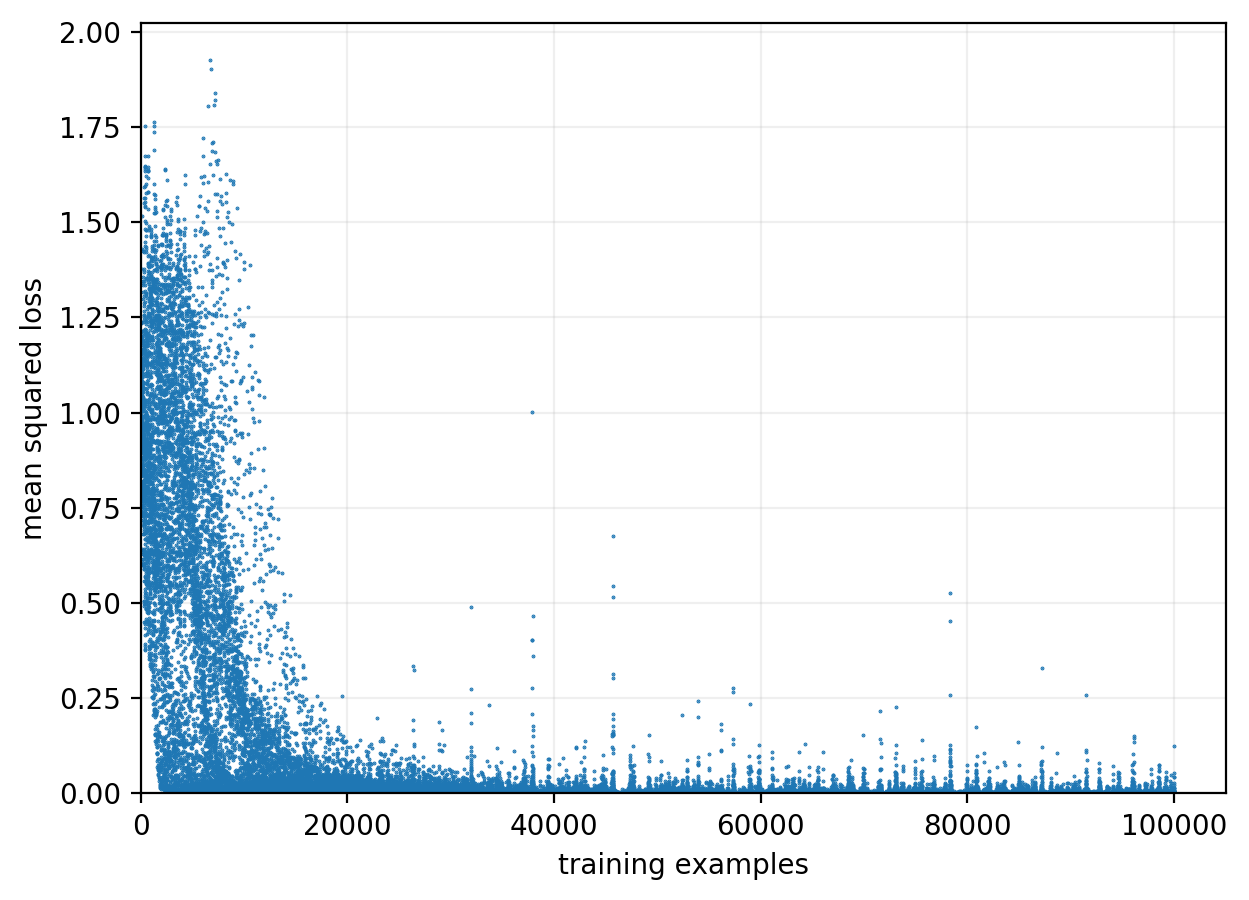

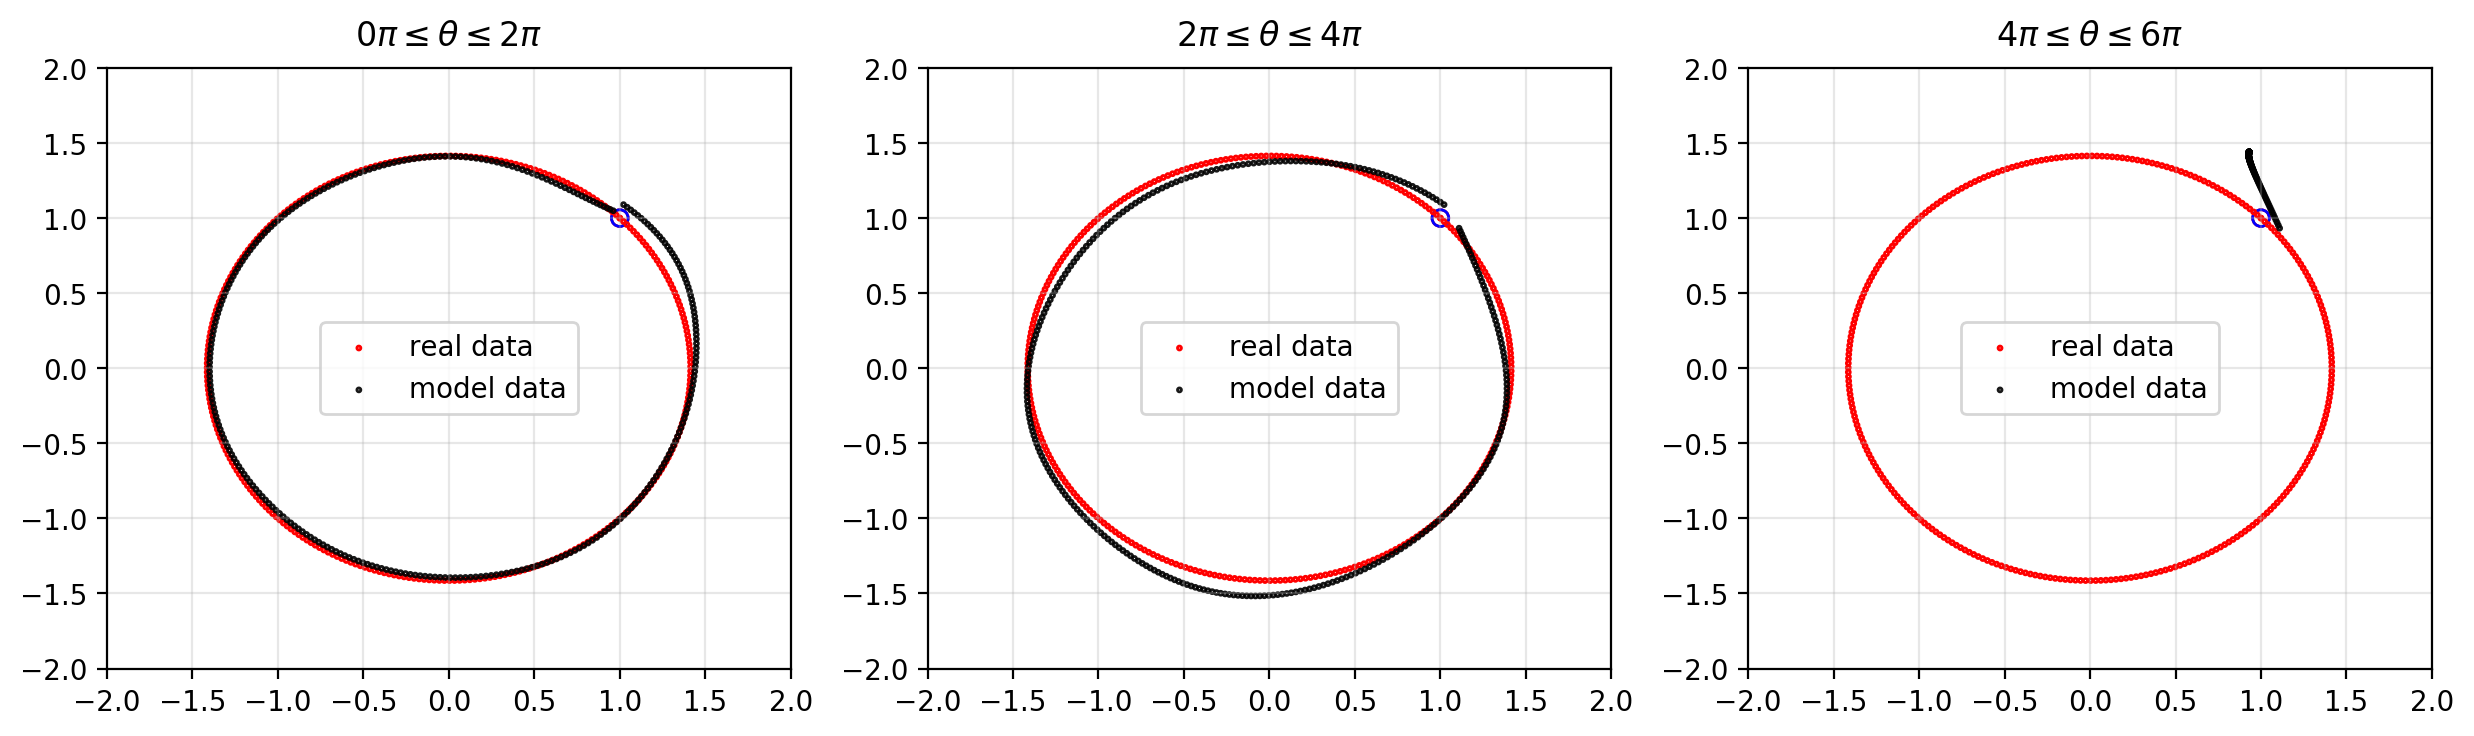

In [75]:
%%time
num_nodes=10
class Rotations(nn.Module):
    def __init__(self):
        super(Rotations, self).__init__()
        self.input=nn.Linear(1,num_nodes,bias=True)
        self.rnn=nn.GRU(num_nodes,num_nodes,1)
        # self.rnn=nn.LSTM(num_nodes,num_nodes,1)
        self.out=nn.Linear(num_nodes,2,bias=True)        
    def forward(self,x,hidden):
        x=self.input(x)
        x,hidden=self.rnn(x.view(1,1,-1))
        x=self.out(x.view(-1))
        return x

model=Rotations()
optimizer=torch.optim.Adam(model.parameters())
criterion=nn.MSELoss()
print(model)

total_loss,theta=train_models([model],[optimizer],num_samples=100000,circle_interval=2.0,recurrent=True)

fig,ax=plt.subplots(figsize=(7,5))
ax.plot(total_loss,marker='.',ls='',markersize=.8)
ax.set_ylim(0,);ax.set_xlim(0,);ax.grid(alpha=0.2);
ax.set_xlabel('training examples');ax.set_ylabel('mean squared loss');

output=plot_circles([model],offset=0,CI=False,recurrent=True)

# Convolutional NNs (CNNs)
------------------------------------------
![Convolutional Architecture](https://cdn-images-1.medium.com/max/1600/1*NQQiyYqJJj4PSYAeWvxutg.png)

### Example CNN implemented in pytorch

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(32*32*32, 4)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


model = CNN()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
criterion = nn.SmoothL1Loss()
total_loss = []

For convolutions in PyTorch, very useful to use a dataloader:

In [ ]:
dataset = dset.ImageFolder(root='/scratch/rag394/data/gaussian_generator/',
                           transform=transforms.Compose([
                                   transforms.Grayscale(),
                                   transforms.Resize(128),
                                   transforms.CenterCrop(128),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,),(0.5,)),
                               ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                         shuffle=False, num_workers=8)

Training:

In [ ]:
num_epochs = 20
for epoch in range(num_epochs):
    iter_mean = []
    for k, data in enumerate(dataloader):
        img, _ = data
        img = Variable(img).cuda()
        # ===================forward=====================
        output = model(img)
        loss   = criterion(output, targets[k,:])
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        iter_mean.append(loss.data[0])
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, np.mean(iter_mean)))
    total_loss.append(np.mean(iter_mean))

See my [github notebook](https://github.com/richardagalvez/gaussian_generator/blob/master/main.ipynb) for more details on implementing a CNN, or, come ask me! But, here are some of the results from a CNN I wrote that learns the covariance matrix from images of gaussians!

![guassian generator](https://cdn.pbrd.co/images/HsbroEW.png)

# GANs
----------------------

GANs are super cool!

![le GAN](https://cdn-images-1.medium.com/max/1600/0*Mwpzq1rqmc-2LJsx.)
![le GAN 2](http://www.timzhangyuxuan.com/static/images/project_DCGAN/structure_cnn.png)

There are pytorch implementations online which I suggest working with, to start. If you need help with this, I've been able to train these models before. Currently the state of the art GAN is the Wasserstein GAN:

Here's a link to a github repo which implements it: [link](https://github.com/martinarjovsky/WassersteinGAN) 

Hope this reference helps you, good luck during FDL!

# Appendix 1: Definitions

In [76]:
def train_models(models,optimizers,num_samples=1000,circle_interval=1.0,save_models=False,cuda=False,recurrent=False):
    total_loss=[]
    for k in range(num_samples):
        # =================== progress indicator ===================
        if k % (num_samples//20) ==0:
            print('{0}: %: {1:.3f}'.format(k,k/num_samples * 100))
        # =================== data calc ===================
        x,theta=torch.ones(2),circle_interval*2*np.pi*torch.rand(1)
        R = torch.zeros(2,2)
        R[0,:]=torch.Tensor([np.cos(theta[0]),-np.sin(theta[0])])
        R[1,:]=torch.Tensor([np.sin(theta[0]), np.cos(theta[0])])
        data,target=Variable(theta),Variable(torch.mv(R,x))
        if cuda:
            data,target=data.cuda(),target.cuda()
        # =================== learning phases =================
        for l,model in enumerate(models):
            loss_iter=[]
            # =================== forward =====================
            if recurrent:
                output=model(data,None)
            else:
                output=model(data)
            loss=criterion(output, target)
            loss_iter.append(loss.data.item())
            # =================== backward ====================
            optimizers[l].zero_grad()
            loss.backward()
            optimizers[l].step()
        total_loss.append(np.mean(loss_iter))
    # =================== save model state ====================
    if save_models:
        for l,model in enumerate(models):
            torch.save(model.state_dict(), '/scratch/rag394/data/symmetries/rotations_{}.pth'.format(l))
    return total_loss,theta
        
def plot_circles(models,offset=0,CI=False,cuda=False,recurrent=False):
    fig, axes = plt.subplots(figsize=(5*3,3.9),ncols=3)
    x = torch.ones(2)
    for k,ax in enumerate(axes):
        ax.scatter(x[0],x[1], facecolors='none', edgecolors='r')
        ax.scatter(x[0],x[1], facecolors='none', edgecolors='b')
        x_real, y_real = [],[]
        x_mean, y_mean = [],[]
        x_std, y_std = [],[]
        for theta in np.linspace((k+offset) *2*np.pi,(k+1+offset) *2*np.pi,300):
            x_model,y_model = [],[]
            # =================== sythetic (real) data ====================
            data = Variable(torch.Tensor([theta]))#.cuda()
            R = torch.zeros(2,2)
            R[0,:] = torch.Tensor([np.cos(theta),-np.sin(theta)])
            R[1,:] = torch.Tensor([np.sin(theta), np.cos(theta)])
            real = torch.mv(R,x)
            if cuda:
                x_real.append(real[0].cpu().numpy())
                y_real.append(real[1].cpu().numpy())
            else:
                x_real.append(real[0].numpy())
                y_real.append(real[1].numpy())
            # =================== predict w/ all models ====================
            for model in models:
                if recurrent:
                    outputs=model(data,None).data
                else:
                    outputs=model(data).data
                    
                xx_model, yy_model = outputs[0],outputs[1]
                
                if cuda:
                    x_model.append(xx_model.cpu().numpy())
                    y_model.append(yy_model.cpu().numpy())
                else:
                    x_model.append(xx_model.numpy())
                    y_model.append(yy_model.numpy())
            # ============== summarize all model predictions ===============
            x_mean.append(np.mean(x_model))
            y_mean.append(np.mean(y_model))
            x_std.append(np.std(x_model))
            y_std.append(np.std(y_model))
        # ============== plotting data ===============
        ax.scatter(x_real,y_real, facecolors='none', edgecolors='r',label='real data',s=2.)
        ax.scatter(x_mean,y_mean, facecolors='none', edgecolors='k',label='model data', alpha=0.9,s=2.)
        if CI:
            ax.fill_betweenx(y_mean,x_mean-3*np.array(x_std),x_mean+3*np.array(x_std), alpha=0.1,color='b')
            ax.fill_between(x_mean,y_mean-3*np.array(y_std),y_mean+3*np.array(y_std), alpha=0.1,color='b')
        ax.legend()
        ax.set_ylim(-2,2);ax.set_xlim(-2,2);ax.grid(alpha=0.3)
        ax.set_title(r'${}\pi \leq \theta \leq {}\pi$'.format(2*(k+offset),2*(k+1+offset)),y=1.01);
    
    return x_mean, y_mean, np.array(x_std), np.array(y_std)
        
def weight_init(m): # so-called xavier normalization https://arxiv.org/abs/1211.5063
    if isinstance(m, nn.Linear):
        size = m.weight.size()
        fan_out = size[0]
        fan_in = size[1]
        variance = np.sqrt(2.0/(fan_in + fan_out))
        m.weight.data.normal_(0.0, variance)